In [56]:
import os
import numpy as np
import tensorflow as tf
import cPickle as pickle

from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from IPython.display import display, Image

import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
# Load the data from "notMNIST.pickle":
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print 'Training set', train_dataset.shape, train_labels.shape
    print 'Validation set', valid_dataset.shape, valid_labels.shape
    print 'Test set', test_dataset.shape, test_labels.shape

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (18724, 28, 28) (18724,)


In [58]:
# Reformat  data as a flat matrix, labels as float 1-hot encodings
image_size = 28
num_labels = 10
num_channels = 1 # for grayscale image, there is only 1 channel (layer)

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (200000, 28, 28, 1), (200000, 10))
('Validation set', (10000, 28, 28, 1), (10000, 10))
('Test set', (18724, 28, 28, 1), (18724, 10))


In [59]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])

Build a network with two convolutional layers, followed by two fully connected layer.

In [60]:
batch_size = 128
patch_size = 5
num_channels = 1
depth = 16 # depth of the convolved cylinder
num_hidden = 64

graph = tf.Graph()

with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    # layer 1, layer 2 are convolutions.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    # layer 3, layer 4 are fully connected networks.
    # here the strides = 2
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME') # [1,2,2,1] denotes the strides
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]]) # shape[0]:num of data, shape[1]*...: vol of convolved cylinder
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        hidden_drop = tf.nn.dropout(hidden, keep_prob)  # Dropout!
        hidden_drop = hidden
        return tf.matmul(hidden, layer4_weights) + layer4_biases
        
    # Training computation.
    keep_prob = tf.placeholder("float")
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimization
    global_step = tf.Variable(0)
    starter_learning_rate = 0.05
    learning_rate = tf.train.exponential_decay(
        starter_learning_rate, global_step,100, 0.95, staircase=True) # decay every 100 steps with a base of 0.9 
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [61]:
num_steps = 5000

Minibatch_accuracy_curve = []
Validation_accuracy_curve = []
Test_accuracy_curve = []

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : 0.5}
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            #print('Minibatch loss at step %d: %f' % (step, l))
            Minibatch_accuracy = accuracy(predictions, batch_labels)
            Validation_accuracy = accuracy(valid_prediction.eval(), valid_labels)
            Test_accuracy = accuracy(test_prediction.eval(), test_labels)
            
            Minibatch_accuracy_curve.append(Minibatch_accuracy)
            Validation_accuracy_curve.append(Validation_accuracy)
            Test_accuracy_curve.append(Test_accuracy)

Initialized


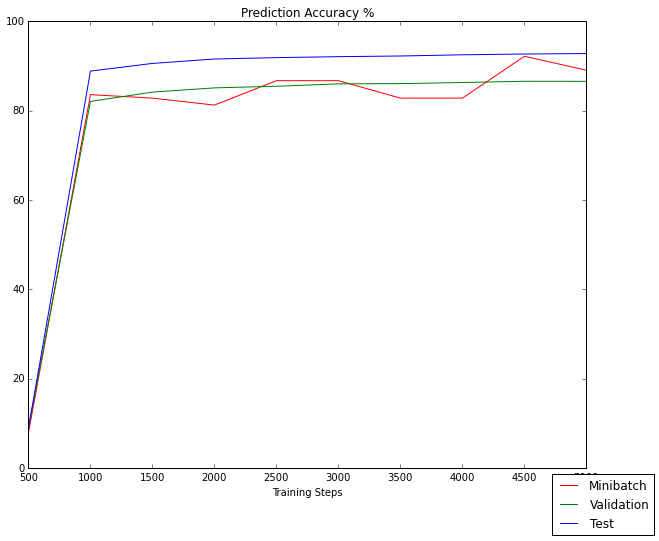

In [86]:
x = 500*np.linspace(1, 10, num = 10)

plt.figure(figsize=(10,8))
l1, =plt.plot(x, Minibatch_accuracy_curve, 'r')
l2, =plt.plot(x, Validation_accuracy_curve, 'g')
l3, =plt.plot(x, Test_accuracy_curve, 'b')
plt.title('Prediction Accuracy %')
plt.xlabel('Training Steps')
plt.figlegend((l1,l2,l3), ('Minibatch', 'Validation', 'Test'),'lower right')
plt.show()